In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

from fbprophet import Prophet

In [2]:
# function to run Prophet and return the forecast
def ProphetForecast(df_input):
    m = Prophet(daily_seasonality=False, yearly_seasonality=True, 
            seasonality_mode='multiplicative', growth='logistic')
    m.fit(df_input)
    # find how many periods we need by finding the last day in the item
    days_to_predict = pd.to_datetime('2016-1-31') - df_input['ds'].max()
    future = m.make_future_dataframe(periods=days_to_predict.days)
    # in logarithmic space 10-2 is 0.01
    future['floor'] = -2
    future['cap'] = df_input['y'].max()
    forecast = m.predict(future)
    return forecast

In [3]:
df_sales = pd.read_csv('../data/sales_train_v2.csv')
df_sales['ds'] = pd.to_datetime(df_sales['date'],  dayfirst=True)

# remove 0 or negative item count
df_sales = df_sales.loc[df_sales['item_cnt_day']>0]


# Create dataframe of most sold items

In [4]:
# find the most sold items
df_sales_totalitem = df_sales.loc[(df_sales['item_cnt_day']>0)&
                                 (df_sales['ds']>pd.to_datetime('2015-05-01'))]
df_sales_totalitem = df_sales_totalitem.groupby(['item_id'])['item_cnt_day'].sum().reset_index(name='item_cnt_total')
df_sales_totalitem = df_sales_totalitem.sort_values(by='item_cnt_total',ascending=False)
# drop items that did not sell more than 1708 items to start, this gives 10 items to loop
df_sales_totalitem = df_sales_totalitem.loc[df_sales_totalitem['item_cnt_total']>1708]
df_sales_totalitem.head(10)

,item_id,item_cnt_total
8373,20949,21439.0
4020,10210,4882.0
4019,10209,4216.0
4520,11373,3719.0
7125,17717,3033.0
1546,3731,2785.0
4017,10207,2146.0
1379,3351,2024.0
736,1814,1775.0
8867,22102,1709.0


# Loop starts here

In [5]:
# create a yhat dataframe to put the forecasted data for each item
yhat = df_sales[['ds']]
for index, row in df_sales_totalitem.iterrows():
    # create df for prophet
    df_fbprophet = df_sales.loc[(df_sales['item_id']==row['item_id'])]
    # sum the total sold for each day for this item
    df_fbprophet = df_fbprophet.groupby(['ds'])['item_cnt_day'].sum().reset_index(name='y')

    # convert to log space
    df_fbprophet['y'] = np.log(df_fbprophet['y'])

    # in logarithmic space 10-2 is 0.01
    df_fbprophet['floor']=-2
    df_fbprophet['cap']=df_fbprophet['y'].max()
    forecast = ProphetForecast(df_fbprophet)
    # forecast for the whole month of November
    print('item_id: ' + str(row['item_id']) + ', total items:' + str(row['item_cnt_total']), end="")
    print(', Nov 2015 forecast: '
          + str(int(round(np.exp(forecast.loc[(forecast['ds']>=pd.to_datetime('2015-11-1')) 
                             & (forecast['ds']<=pd.to_datetime('2015-11-30'))]['yhat']).sum()))))
    # make a new column in forecast with the name of our item
    forecast[str(int(row['item_id']))] = np.exp(forecast['yhat'])
    # merge that data into the correct date time in our dataframe
    yhat = pd.merge(yhat,forecast[['ds', str(int(row['item_id']))]], how='outer', on='ds')


INFO:numexpr.utils:NumExpr defaulting to 2 threads.


item_id: 20949.0, total items:21439.0, Nov 2015 forecast: 3079
item_id: 10210.0, total items:4882.0, Nov 2015 forecast: 65
item_id: 10209.0, total items:4216.0, Nov 2015 forecast: 49
item_id: 11373.0, total items:3719.0, Nov 2015 forecast: 298
item_id: 17717.0, total items:3033.0, Nov 2015 forecast: 733
item_id: 3731.0, total items:2785.0, Nov 2015 forecast: 51
item_id: 10207.0, total items:2146.0, Nov 2015 forecast: 149
item_id: 3351.0, total items:2024.0, Nov 2015 forecast: 195
item_id: 1814.0, total items:1775.0, Nov 2015 forecast: 19
item_id: 22102.0, total items:1709.0, Nov 2015 forecast: 38


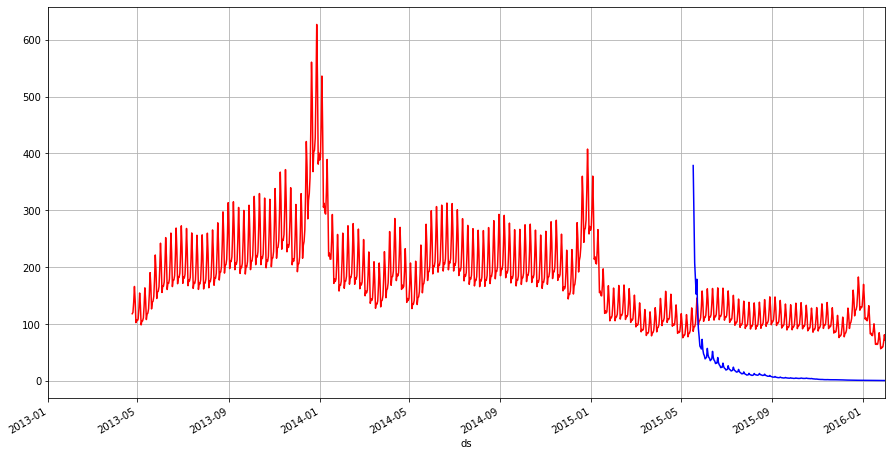

In [6]:
fig, ax = plt.subplots(figsize=(15,8))
ax = yhat.plot(ax=ax, x='ds', y='20949',  color='r',   legend=False, grid=True)
ax = yhat.plot(ax=ax, x='ds', y='10210',  color='b',   legend=False, grid=True)

In [7]:
# 30 days of November
yhat.loc[(yhat['ds']>=pd.to_datetime('2015-11-1'))
             & (yhat['ds']<=pd.to_datetime('2015-11-30'))]

,ds,20949,10210,10209,11373,17717,3731,10207,3351,1814,22102
2928493,2015-11-01,113.725893,2.924863,2.214170,5.237759,22.870824,3.583239,4.720556,24.359536,1.548231,2.171310
2928494,2015-11-02,87.710405,2.754502,2.052338,7.953186,19.427274,3.476828,4.529098,17.568210,1.415073,2.067749
2928495,2015-11-03,93.427466,2.644218,2.092658,7.129849,19.772432,3.344144,4.415489,17.194349,1.328772,1.997143
2928496,2015-11-04,93.528511,2.496138,2.005312,7.836159,20.535414,3.157609,4.303369,18.281849,1.213099,1.857900
2928497,2015-11-05,97.474125,2.449519,1.967230,8.046392,20.644733,3.030037,4.179427,18.985998,1.112665,1.848944
2928498,2015-11-06,113.091436,2.401337,1.929893,7.468994,22.870215,2.923897,4.577046,21.721039,1.019310,1.749887
2928499,2015-11-07,135.366421,2.500749,1.972082,6.503264,27.385029,2.822289,4.917701,23.512253,0.927330,1.679331
2928500,2015-11-08,119.567070,2.331631,1.875970,7.067015,25.533398,2.603463,4.320282,17.972689,0.844742,1.596153
2928501,2015-11-09,92.202715,2.235287,1.757331,10.751354,21.657708,2.441144,4.189931,11.066718,0.776466,1.539769
2928502,2015-11-10,97.925855,2.182489,1.780926,9.598441,21.975527,2.268304,4.139706,8.157442,0.700172,1.497153
